In [1]:
import numpy as np
import plotly.express as px
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
import ast
from openai import OpenAI
client = OpenAI()


# import df

In [2]:
def string_to_list(s):
    if (pd.isna(s)) or (s==''):
        return np.nan 
    
    # Use ast.literal_eval to safely evaluate string representations of lists
    try:
        parsed_list = ast.literal_eval(s)
    except (ValueError, SyntaxError):
        # Fallback in case of any parsing errors
        parsed_list = s.strip('[]').split(',')

    # Strip any extra whitespace and quotes
    return [item.strip().strip('"').strip("'") for item in parsed_list]

In [3]:
df = pd.read_csv('../Input/books_data.csv',
                       converters={
    'categories': string_to_list}, 
    ).dropna()

df = df.explode('categories')
print(df.shape)
df.head()

(40635, 10)


,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
5,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,['Everett Ferguson'],http://books.google.com/books/content?id=kVqRa...,http://books.google.nl/books?id=kVqRaiPlx88C&p...,Wm. B. Eerdmans Publishing,1996,http://books.google.nl/books?id=kVqRaiPlx88C&d...,Religion,5.0
31,Voices from the Farm: Adventures in Community ...,"Twenty-five years ago, at the height of the co...",['Rupert Fike'],http://books.google.com/books/content?id=IjTAB...,http://books.google.nl/books?id=IjTABgAAQBAJ&p...,Book Publishing Company,2012-08-21,https://play.google.com/store/books/details?id...,Biography & Autobiography,1.0
33,The Battleship Bismarck,The Bismarck is perhaps the most famous – and ...,['Stefan Draminski'],http://books.google.com/books/content?id=nxttD...,http://books.google.nl/books?id=nxttDwAAQBAJ&p...,Bloomsbury Publishing,2018-09-20,https://play.google.com/store/books/details?id...,History,1.0
42,Tess and the Highlander,"In 1543, on a windswept isle off of Scotland, ...",['May Mcgoldrick'],http://books.google.com/books/content?id=VmCRS...,http://books.google.nl/books?id=VmCRSPmY3WkC&d...,Harper Collins,2002-11,http://books.google.nl/books?id=VmCRSPmY3WkC&d...,Juvenile Fiction,2.0
43,Beginner's Yoruba (Hippocrene Beginner's Series),"""Beginner's Yoruba"" is now available with two ...",['Kayode J. Fakinlede'],http://books.google.com/books/content?id=xLe4n...,http://books.google.nl/books?id=xLe4nWzeSw0C&p...,Hippocrene Books,2005,http://books.google.nl/books?id=xLe4nWzeSw0C&d...,Foreign Language Study,1.0


# Get embbedings

In [4]:
categories = df['categories'].unique()

In [5]:

# Function to save embeddings and strings to files
def save_embeddings_and_strings(batch_index, batch_categories, embeddings):
    output_dir = "/home/mateus/Work/PageLens/Output/embeddings/category"
    
    # Create directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Save embeddings to a file
    embeddings_file = os.path.join(output_dir, f"embeddings_batch_{batch_index}.pkl")
    with open(embeddings_file, 'wb') as f:
        pickle.dump(embeddings, f)
    
    # Save batch categories to a file
    strings_file = os.path.join(output_dir, f"batch_{batch_index}_strings.pkl")
    with open(strings_file, 'wb') as f:
        pickle.dump(batch_categories, f)

# Process categories in batches of 500
batch_size = 500
for i in range(0, len(categories), batch_size):
    batch_categories = categories[i:i + batch_size]
    
    # Generate embeddings for the batch
    response = client.embeddings.create(input=batch_categories, model="text-embedding-3-small").data
    
    # Save embeddings and batch strings
    save_embeddings_and_strings(i // batch_size, batch_categories, response)

print("Processing complete.")


Processing complete.


# Clustering

In [6]:


def load_embeddings(embedding_dir):
    embeddings = {}
    for file_name in os.listdir(embedding_dir):
        if file_name.startswith("embeddings_batch_") and file_name.endswith(".pkl"):
            # Extract batch index from the file name
            batch_index = file_name.split("_")[2].split(".")[0]
            
            # Load the corresponding categories
            strings_file = os.path.join(embedding_dir, f"batch_{batch_index}_strings.pkl")
            with open(strings_file, 'rb') as f:
                batch_categories = pickle.load(f)
            
            # Load the embeddings
            embeddings_file = os.path.join(embedding_dir, file_name)
            with open(embeddings_file, 'rb') as f:
                batch_embeddings = pickle.load(f)
            
            # Store embeddings with corresponding categories
            for category, embedding in zip(batch_categories, batch_embeddings):
                embeddings[category] = embedding
    
    return embeddings

# Example usage:
embeddings_dir = "/home/mateus/Work/PageLens/Output/embeddings/category"
embeddings = load_embeddings(embeddings_dir)


In [7]:

all_categories = df['categories'].to_list()
# Create a matrix of embeddings weighted by category frequency
embedding_matrix = []
for category in all_categories:
    if category in embeddings:
        weighted_embedding = embeddings[category].embedding
        embedding_matrix.append(weighted_embedding)

embedding_matrix = np.array(embedding_matrix)


In [8]:
# Apply PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
embedding_2d_pca = pca.fit_transform(embedding_matrix)
df['x_axis'], df['y_axis'] =embedding_2d_pca[:, 0], embedding_2d_pca[:, 1]


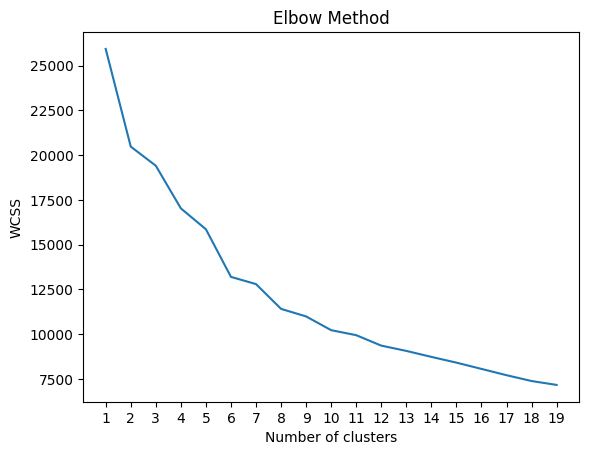

In [24]:
wcss = []
for i in range(1, 20):  # Test a range of n_clusters
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(embedding_matrix)
    wcss.append(kmeans.inertia_)

# Plot the WCSS to visualize the "elbow"
plt.plot(range(1, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.xticks(range(1,20))
plt.ylabel('WCSS')
plt.show()

In [27]:
# Apply clustering (KMeans in this case)
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters = kmeans.fit_predict(embedding_matrix)

pca_centroids = pca.transform(kmeans.cluster_centers_)
# Map cluster labels back to categories
clustered_categories = pd.DataFrame({
    'category': all_categories,
    'cluster': clusters,
})

df['cluster'] = clusters


ValueError: All arrays must be of the same length

In [10]:

# Function to find the median category
def find_median_category(categories):
    sorted_categories = sorted(categories)
    median_index = len(sorted_categories) // 2
    return sorted_categories[median_index]

# Group by cluster and find the median category
median_categories = clustered_categories.groupby('cluster')['category'].apply(find_median_category)

df_median_categories = pd.DataFrame(median_categories)

df_median_categories['x_axis']= pca_centroids [:,0]
df_median_categories['y_axis']= pca_centroids [:,1]
df_median_categories.to_csv('../Output/cluster_centorids.cvs')


cluster_name_dict = median_categories.to_dict()
cluster_name_dict

{0: 'Juvenile Fiction',
 1: 'History',
 2: 'Religion',
 3: 'Computers',
 4: 'Gardening',
 5: 'Fiction',
 6: 'Biography & Autobiography',
 7: 'Performing Arts'}

In [11]:
df['cluster_name'] = df['cluster'].map(cluster_name_dict)
df.to_parquet('../Input/bookes_data_category_clustered.parquet')
df.head()

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount,x_axis,y_axis,cluster,cluster_name
5,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,['Everett Ferguson'],http://books.google.com/books/content?id=kVqRa...,http://books.google.nl/books?id=kVqRaiPlx88C&p...,Wm. B. Eerdmans Publishing,1996,http://books.google.nl/books?id=kVqRaiPlx88C&d...,Religion,5.0,-0.329316,0.457113,2,Religion
31,Voices from the Farm: Adventures in Community ...,"Twenty-five years ago, at the height of the co...",['Rupert Fike'],http://books.google.com/books/content?id=IjTAB...,http://books.google.nl/books?id=IjTABgAAQBAJ&p...,Book Publishing Company,2012-08-21,https://play.google.com/store/books/details?id...,Biography & Autobiography,1.0,-0.274471,-0.368388,6,Biography & Autobiography
33,The Battleship Bismarck,The Bismarck is perhaps the most famous – and ...,['Stefan Draminski'],http://books.google.com/books/content?id=nxttD...,http://books.google.nl/books?id=nxttDwAAQBAJ&p...,Bloomsbury Publishing,2018-09-20,https://play.google.com/store/books/details?id...,History,1.0,-0.365257,0.146197,1,History
42,Tess and the Highlander,"In 1543, on a windswept isle off of Scotland, ...",['May Mcgoldrick'],http://books.google.com/books/content?id=VmCRS...,http://books.google.nl/books?id=VmCRSPmY3WkC&d...,Harper Collins,2002-11,http://books.google.nl/books?id=VmCRSPmY3WkC&d...,Juvenile Fiction,2.0,0.236387,-0.555932,0,Juvenile Fiction
43,Beginner's Yoruba (Hippocrene Beginner's Series),"""Beginner's Yoruba"" is now available with two ...",['Kayode J. Fakinlede'],http://books.google.com/books/content?id=xLe4n...,http://books.google.nl/books?id=xLe4nWzeSw0C&p...,Hippocrene Books,2005,http://books.google.nl/books?id=xLe4nWzeSw0C&d...,Foreign Language Study,1.0,-0.254290,0.020118,7,Performing Arts


In [16]:
df.columns

Index(['Title', 'description', 'authors', 'image', 'previewLink', 'publisher',
       'publishedDate', 'infoLink', 'categories', 'ratingsCount', 'x_axis',
       'y_axis', 'cluster', 'cluster_name'],
      dtype='object')

In [17]:
df[['Title', 'authors', 'publisher','categories', 'ratingsCount', 'x_axis','y_axis', 'cluster', 'cluster_name']].head().to_clipboard()

In [20]:
df

,Title,authors,publisher,categories,ratingsCount,x_axis,y_axis,cluster,cluster_name
0,The Church of Christ: A Biblical Ecclesiology ...,[Everett Ferguson],Wm. B. Eerdmans Publishing,Religion,5.0,-0.329316,0.457113,2,Religion
1,Voices from the Farm: Adventures in Community ...,[Rupert Fike],Book Publishing Company,Biography & Autobiography,1.0,-0.274471,-0.368388,6,Biography & Autobiography
2,The Battleship Bismarck,[Stefan Draminski],Bloomsbury Publishing,History,1.0,-0.365257,0.146197,1,History
3,Tess and the Highlander,[May Mcgoldrick],Harper Collins,Juvenile Fiction,2.0,0.236387,-0.555932,0,Juvenile Fiction
4,Beginner's Yoruba (Hippocrene Beginner's Series),[Kayode J. Fakinlede],Hippocrene Books,Foreign Language Study,1.0,-0.254290,0.020118,7,Performing Arts


In [19]:
df['publisher'].value_counts()

publisher
Wm. B. Eerdmans Publishing    1
Book Publishing Company       1
Bloomsbury Publishing         1
Harper Collins                1
Hippocrene Books              1
Name: count, dtype: int64

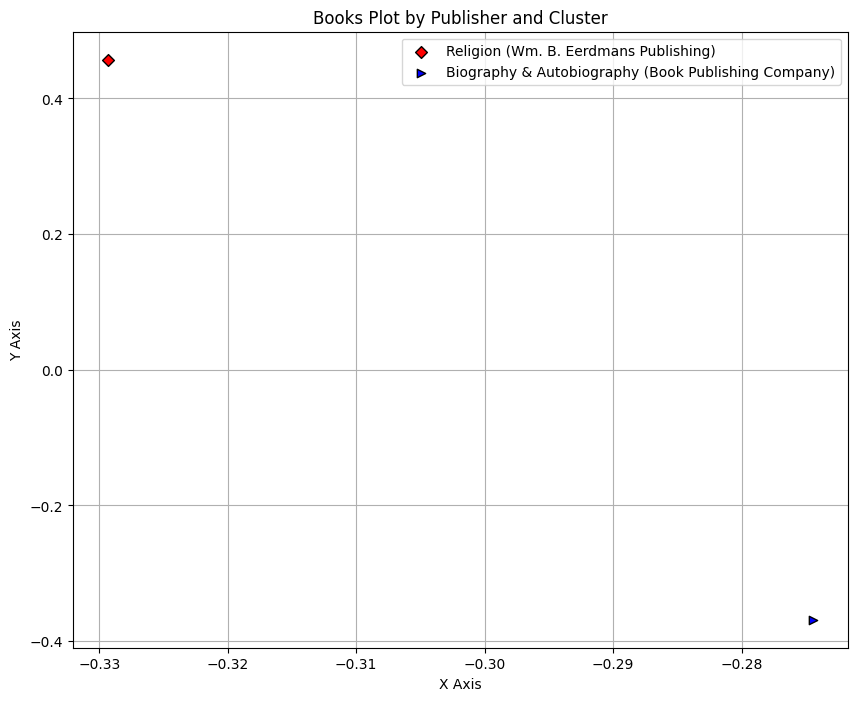

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Sample DataFrame
data = {
    "Title": ["The Church of Christ: A Biblical Ecclesiology for Today", "Voices from the Farm: Adventures in Community Living", 
              "The Battleship Bismarck", "Tess and the Highlander", "Beginner's Yoruba (Hippocrene Beginner's Series)"],
    "authors": [["Everett Ferguson"], ["Rupert Fike"], ["Stefan Draminski"], ["May Mcgoldrick"], ["Kayode J. Fakinlede"]],
    "publisher": ["Wm. B. Eerdmans Publishing", "Book Publishing Company", "Bloomsbury Publishing", 
                  "Harper Collins", "Hippocrene Books"],
    "categories": ["Religion", "Biography & Autobiography", "History", "Juvenile Fiction", "Foreign Language Study"],
    "ratingsCount": [5.0, 1.0, 1.0, 2.0, 1.0],
    "x_axis": [-0.3293163960657735, -0.27447120350520776, -0.3652566172932965, 0.23638717595602815, -0.2542901206398405],
    "y_axis": [0.4571133586701495, -0.36838759930233733, 0.14619672597988825, -0.5559319621002672, 0.020118231990624173],
    "cluster": [2, 6, 1, 0, 7],
    "cluster_name": ["Religion", "Biography & Autobiography", "History", "Juvenile Fiction", "Performing Arts"]
}

df = pd.DataFrame(data)

# Function to plot books from two publishers
def plot_books(df, publisher1, publisher2):
    # Filter the dataframe for the two publishers
    df_pub1 = df[df['publisher'] == publisher1]
    df_pub2 = df[df['publisher'] == publisher2]
    
    # Set up the plot
    plt.figure(figsize=(10, 8))
    
    # Define different markers for each cluster
    markers = ['o', 's', 'D', 'v', '^', '<', '>', 'p']
    
    # Plot books from the first publisher
    for cluster_name, group in df_pub1.groupby('cluster_name'):
        plt.scatter(group['x_axis'], group['y_axis'], 
                    label=f"{cluster_name} ({publisher1})", 
                    marker=markers[group['cluster'].iloc[0] % len(markers)], 
                    color='red', edgecolor='black')
    
    # Plot books from the second publisher
    for cluster_name, group in df_pub2.groupby('cluster_name'):
        plt.scatter(group['x_axis'], group['y_axis'], 
                    label=f"{cluster_name} ({publisher2})", 
                    marker=markers[group['cluster'].iloc[0] % len(markers)], 
                    color='blue', edgecolor='black')
    
    # Adding labels and title
    plt.xlabel('X Axis')
    plt.ylabel('Y Axis')
    plt.title('Books Plot by Publisher and Cluster')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function with two publishers
plot_books(df, "Wm. B. Eerdmans Publishing", "Book Publishing Company")
